In [11]:
import helper
import pandas as pd
from utils import *

import time
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn

from IPython.display import Image

Data Manipulation

In [12]:
df = pd.read_csv('MRK.csv')
df = df.drop(['Date'], axis=1)
df

,Close,Volume,ma7,ma21,26ema,12ema,MACD,momentum,pos,neg,...,PFE,JNJ,BMY,VTRS,AMGN,NYSE,NASDAQ,FT6,FT9,ARIMA
0,31.011450,14227229,30.050436,29.200291,29.514006,29.867322,0.353316,30.011450,0.000000,0.000000,...,9.982087,42.442802,14.896735,14.296743,46.293800,6671.140137,2017.979980,50.337802,47.947327,31.011450
1,31.440840,20081566,30.318975,29.299346,29.688906,30.115697,0.426791,30.440840,0.000000,0.000000,...,10.023851,42.345844,15.140837,14.335833,46.278458,6697.220215,2024.229980,50.140845,47.659130,31.440840
2,31.183207,10438080,30.564340,29.420211,29.822316,30.283528,0.461212,30.183207,0.000000,0.000000,...,10.005951,41.992607,15.114449,14.208794,46.953163,6687.939941,2024.430054,49.944470,47.372320,31.183207
3,31.364504,10302154,30.858779,29.556525,29.957940,30.452906,0.494965,30.364504,0.000000,0.000000,...,10.059650,41.895649,15.028677,14.541050,46.194138,6722.310059,2027.729980,49.748691,47.086936,31.364504
4,30.839695,12640452,30.973283,29.664667,30.034423,30.513340,0.478916,29.839695,0.000000,0.000000,...,10.029818,41.757114,14.593256,14.462871,45.703426,6709.040039,2028.770020,49.553518,46.803017,30.839695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2712,78.301529,13675457,75.931026,74.702836,75.305196,75.725497,0.420300,77.301529,0.124278,0.019176,...,32.118999,142.130844,56.987370,17.140457,209.706986,12302.190430,9682.910156,55.622779,55.790021,76.887436
2713,77.814888,9292930,76.515814,74.863687,75.491099,76.046941,0.555842,76.814888,0.491229,0.013877,...,31.985760,140.295029,57.630974,17.296814,209.593124,12286.980470,9615.809570,55.415062,55.480641,78.191500
2714,78.492363,10413347,77.157852,75.097238,75.713415,76.423160,0.709745,77.492363,0.825178,0.013980,...,31.967995,140.840057,58.047424,17.267496,214.138351,12641.440430,9814.080078,55.207594,55.171523,77.972240
2715,79.103050,9956838,77.684024,75.428935,75.964499,76.835451,0.870952,78.103050,0.000000,0.000000,...,32.500950,140.333298,58.142071,18.352213,214.214249,12836.599610,9924.750000,55.000389,54.862711,78.309688


In [13]:
target = "Close"
features = list(df.columns.difference([target]))
features

['12ema',
 '26ema',
 'AMGN',
 'ARIMA',
 'BMY',
 'FT6',
 'FT9',
 'JNJ',
 'MACD',
 'NASDAQ',
 'NYSE',
 'PFE',
 'SNP',
 'VTRS',
 'Volume',
 'ma21',
 'ma7',
 'momentum',
 'neg',
 'neu',
 'pos']

In [14]:
size = int(len(df) * 0.8)

df_train = df.loc[:size].copy()
df_test = df.loc[size:].copy()
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [15]:
df_train

,Close,Volume,ma7,ma21,26ema,12ema,MACD,momentum,pos,neg,...,PFE,JNJ,BMY,VTRS,AMGN,NYSE,NASDAQ,FT6,FT9,ARIMA
0,-1.491819,0.084065,-1.582933,-1.657120,-1.627094,-1.599683,0.516385,-1.491819,-0.607619,-0.426041,...,-1.529396,-1.213278,-1.486902,-1.469054,-1.126034,-1.644286,-1.422664,0.368855,0.151585,-1.491737
1,-1.449951,0.902056,-1.556741,-1.647468,-1.610017,-1.575435,0.652257,-1.449951,-0.607619,-0.426041,...,-1.522755,-1.217057,-1.470380,-1.466214,-1.126400,-1.629206,-1.418255,0.349184,0.122940,-1.449880
2,-1.475072,-0.445370,-1.532808,-1.635690,-1.596992,-1.559051,0.715908,-1.475072,-0.607619,-0.426041,...,-1.525601,-1.230825,-1.472166,-1.475445,-1.110308,-1.634572,-1.418114,0.329572,0.094432,-1.474994
3,-1.457394,-0.464362,-1.504089,-1.622406,-1.583750,-1.542515,0.778326,-1.457394,-0.607619,-0.426041,...,-1.517062,-1.234604,-1.477972,-1.451301,-1.128411,-1.614699,-1.415786,0.310019,0.066066,-1.457321
4,-1.508565,-0.137646,-1.492921,-1.611868,-1.576283,-1.536615,0.748647,-1.508565,-0.607619,-0.426041,...,-1.521806,-1.240004,-1.507442,-1.456982,-1.140115,-1.622372,-1.415053,0.290526,0.037846,-1.508480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2169,0.448954,-0.073319,0.529771,0.567146,0.577198,0.532817,-0.839659,0.448954,-0.501737,3.978460,...,1.457947,1.621885,1.167733,0.298472,1.334893,1.638853,2.031975,0.878754,0.883835,0.557000
2170,0.709460,1.498791,0.543998,0.573345,0.588024,0.561007,-0.510740,0.709460,0.921086,1.741817,...,1.495669,1.670248,1.143666,0.321906,1.366273,1.657032,2.056827,0.880191,0.890271,0.451715
2171,0.740162,-0.020076,0.570855,0.579322,0.600325,0.589589,-0.202331,0.740162,0.485362,-0.301801,...,1.559405,1.697235,1.187588,0.440499,1.440695,1.764247,2.158383,0.881709,0.896821,0.707860
2172,0.713181,-0.584010,0.609812,0.583042,0.609714,0.609617,-0.000775,0.713181,-0.366465,-0.303263,...,1.538592,1.675506,1.125616,0.360254,1.425429,1.734538,2.140556,0.883309,0.903484,0.730594


In [16]:
from factory import SequenceDataset

batch_size = 1
sequence_length = 10

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 10, 21])
Target shape: torch.Size([1])


Classic LSTM

In [17]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

In [8]:
from factory import ShallowRegressionLSTM
learning_rate = 0.0001
num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

classical_loss_train = []
classical_loss_test = []
print("Untrained test\n--------")
test_loss = test_model(test_loader, model, loss_function)
print()
classical_loss_test.append(test_loss)

for ix_epoch in range(20):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model, loss_function)
    print()
    classical_loss_train.append(train_loss)
    classical_loss_test.append(test_loss)

Untrained test
--------
Test loss: 7.929783337146921

Epoch 0
---------
Train loss: 0.20602377654180995
Test loss: 2.3081659480668377

Epoch 1
---------
Train loss: 0.016666612679628406
Test loss: 1.6322666254324276

Epoch 2
---------
Train loss: 0.00876951087394336
Test loss: 1.4578223572017661

Epoch 3
---------
Train loss: 0.006696450642744458
Test loss: 1.3744002738340053

Epoch 4
---------
Train loss: 0.00544091963214617
Test loss: 1.2772512881700442

Epoch 5
---------
Train loss: 0.004649388731226387
Test loss: 1.1978125533381003

Epoch 6
---------
Train loss: 0.004006830644862422
Test loss: 1.1872875070755184

Epoch 7
---------
Train loss: 0.003444667859183806
Test loss: 1.1138024713317571

Epoch 8
---------
Train loss: 0.002986024296645566
Test loss: 1.1600345051684258

Epoch 9
---------
Train loss: 0.0025992749007872715
Test loss: 1.0815694066310764

Epoch 10
---------
Train loss: 0.002242624436892697
Test loss: 0.9794569220687075

Epoch 11
---------
Train loss: 0.001953414473

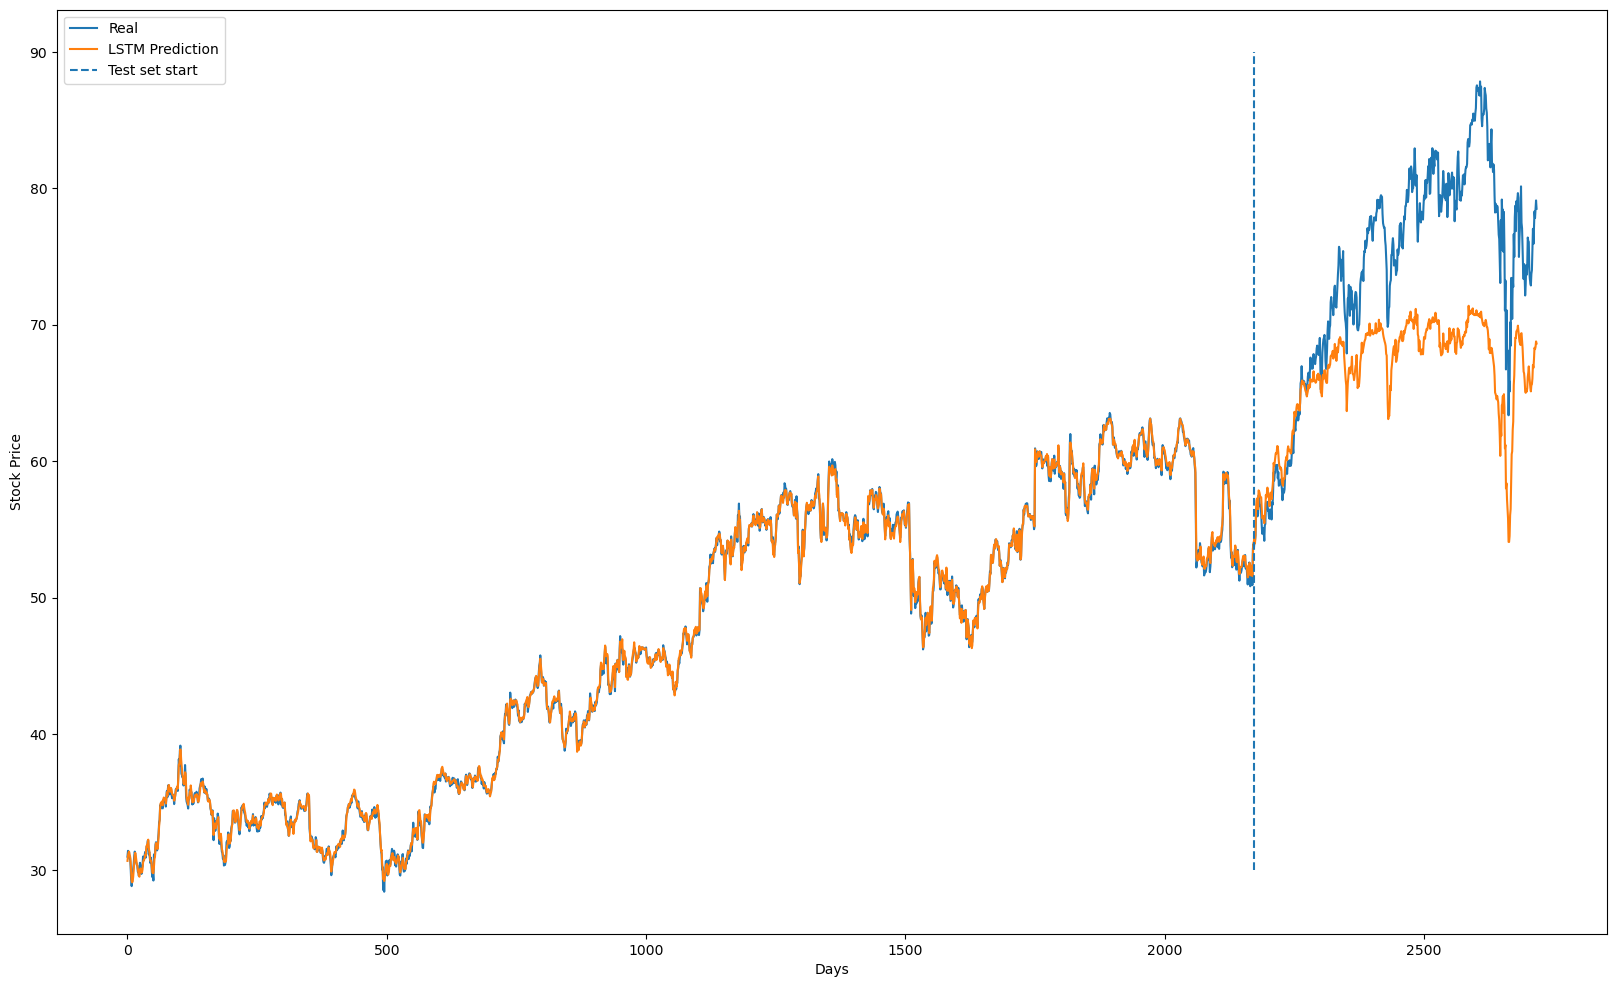

In [9]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean
    
plt.figure(figsize=(20, 12))
plt.plot(range(2718), df_out["Close"], label = "Real")
plt.plot(range(2718), df_out["Model forecast"], label = "LSTM Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.vlines(size, ymin = 30, ymax = 90, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

QLSTM

In [18]:
from factory import QShallowRegressionLSTM

learning_rate = 0.05
num_hidden_units = 16

Qmodel = QShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units, n_qubits=4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(Qmodel.parameters(), lr=learning_rate)

quantum_loss_train = []
quantum_loss_test = []
print("Untrained test\n--------")
start = time.time()
test_loss = test_model(test_loader, Qmodel, loss_function)
end = time.time()
print("Execution time", end - start)
quantum_loss_test.append(test_loss)

for ix_epoch in range(20):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_loss_test.append(test_loss)

ContextualVersionConflict: (websocket-client 0.58.0 (/opt/anaconda3/lib/python3.9/site-packages), Requirement.parse('websocket-client>=1.5.1'), {'qiskit-ibm-runtime', 'qiskit-ibm-provider', 'qiskit-ibmq-provider'})

In [ ]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, Qmodel).numpy()
df_test[ystar_col_Q] = predict(test_loader, Qmodel).numpy()

df_out_Q = pd.concat((df_train, df_test))[[target, ystar_col_Q]]

for c in df_out_Q.columns:
    df_out_Q[c] = df_out_Q[c] * target_stdev + target_mean
    
plt.figure(figsize=(20, 12))
plt.plot(range(2718), df_out_Q["Close"], label = "Real")
plt.plot(range(2718), df_out_Q["Model forecast"], label = "QLSTM Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.vlines(size, ymin = 30, ymax = 90, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(20, 12))
plt.plot(range(2718), df_out_Q["Model forecast"], label = "QLSTM")
plt.plot(range(2718), df_out["Model forecast"], label = "LSTM")
plt.plot(range(2718), df_out["Close"], label = "Real")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.vlines(size, ymin = 30, ymax = 90, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

In [33]:
from numpy import diff
def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


#y1 = df_out_Q["Model forecast"].iloc[size:].to_numpy()
y2 = df_out["Model forecast"].iloc[size:].to_numpy()
y3 = df["Close"].iloc[size:].to_numpy()

n = 7
#y1 = moving_average(y1, n)
y2 = moving_average(y2, n)
y3 = moving_average(y3, n)

#dy1 = diff(y1)/1
dy2 = diff(y2)/1
dy3 = diff(y3)/1

#plt.figure(figsize=(30, 10))
#plt.plot(dy1, label = "QLSTM")
#plt.plot(dy2, label = "LSTM")
#plt.plot(dy3, label = "Real")
#plt.ylabel('Change in Stock Price over Time')
#plt.xlabel('Days')
#plt.axhline(y = 0, color = 'r', linestyle = 'dashed')    
#plt.legend()
#plt.show()

for elements in range(y2.size):
    print(str(elements), ": ", str(y2[elements]))

0 :  54.61258316040039
1 :  54.96636199951172
2 :  55.50331660679409
3 :  55.91594478062221
4 :  56.05639048985073
5 :  56.091861724853516
6 :  56.1343868800572
7 :  56.19599042619978
8 :  56.09083066667829
9 :  55.752104078020366
10 :  55.47297668457031
11 :  55.209241594587056
12 :  54.87381090436663
13 :  54.563471112932476
14 :  54.29816327776228
15 :  54.169401441301616
16 :  54.297215597970144
17 :  54.57435008457729
18 :  54.78523581368582
19 :  55.10734503609793
20 :  55.450714111328125
21 :  55.74589811052595
22 :  55.925763266427175
23 :  56.007134028843474
24 :  55.97443880353655
25 :  56.02317810058594
26 :  55.99352046421596
27 :  55.88806915283203
28 :  55.891153063092915
29 :  56.03076171875
30 :  56.21630423409598
31 :  56.504803793770925
32 :  56.75957924979074
33 :  57.01748057774135
34 :  57.3548823765346
35 :  57.63615253993443
36 :  57.86020006452288
37 :  58.132899148123606
38 :  58.286790575299946
39 :  58.44640786307199
40 :  58.60359900338309
41 :  58.606894901

In [ ]:
zero1 = np.where(np.diff(np.sign(dy1)))[0]
zero2 = np.where(np.diff(np.sign(dy2)))[0]
zero3 = np.where(np.diff(np.sign(dy3)))[0]

In [ ]:
print(zero1)
print(zero2)
print(zero3)

In [ ]:
from scipy import integrate
y1 = df_out_Q["Model forecast"].iloc[size:].to_numpy()
y2 = df_out["Model forecast"].iloc[size:].to_numpy()
y3 = df["Close"].iloc[size:].to_numpy()

y1 = y1[1:]
y2 = y2[1:]

n = 7
y1 = moving_average(y1, n)
y2 = moving_average(y2, n)
y3 = moving_average(y3, n)

error1 = abs(y1-y3)
error2 = abs(y2-y3)

interr1 = np.zeros(shape=(len(error1)))
interr2 = np.zeros(shape=(len(error2)))

for i in range(len(error1)):
    x = np.arange(0, i+1)
    y1 = error1[0:i+1]
    y2 = error2[0:i+1]
    interr1[i] = integrate.simpson(y1, x)
    interr2[i] = integrate.simpson(y2, x)

plt.figure(figsize=(30, 10))
plt.plot(interr1, label = "QLSTM")
plt.plot(interr2, label = "LSTM")
plt.ylabel('Error')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(30, 10))
plt.plot(error1, label = "QLSTM")
plt.plot(error2, label = "LSTM")
plt.ylabel('Error')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(21), quantum_loss_test, label = "QLSTM")
plt.plot(range(21), classical_loss_test, label = "LSTM")
plt.ylabel('Train Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [49]:
from numpy import diff
def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

size = int(len(df) * 0.8)
y = df["Close"].iloc[size:].to_numpy()

n = 7
y = moving_average(y, n)

for elements in range(y.size):
    print(str(elements), ": ", str(y[elements]))

0 :  55.646128
1 :  56.124590714285716
2 :  56.52262828571428
3 :  56.65621571428572
4 :  56.67529957142858
5 :  56.75027185714286
6 :  56.781624285714294
7 :  56.665757857142864
8 :  56.26363100000001
9 :  55.91466685714287
10 :  55.658396571428575
11 :  55.38167885714285
12 :  55.012268
13 :  54.88685928571427
14 :  54.897764285714274
15 :  55.22355528571428
16 :  55.5166302857143
17 :  55.71428557142859
18 :  56.03735014285717
19 :  56.35223600000001
20 :  56.51444942857146
21 :  56.5839695714286
22 :  56.41493985714286
23 :  56.34541971428569
24 :  56.33587814285712
25 :  56.24591071428569
26 :  56.15457971428571
27 :  56.23364214285714
28 :  56.36450371428571
29 :  56.65212642857143
30 :  57.040621714285734
31 :  57.34869114285714
32 :  57.73582300000002
33 :  58.22519085714287
34 :  58.615049
35 :  58.996727999999976
36 :  59.25299871428573
37 :  59.33069757142857
38 :  59.35387128571431
39 :  59.36750285714288
40 :  59.231188571428575
41 :  59.01990185714288
42 :  58.87677228571

In [63]:
qlstm = [  6, 14, 21, 26, 119, 124,131, 134, 150, 151, 162, 174, 182, 188, 191,
         197, 220, 222, 224, 225, 240, 269, 279, 281, 282, 285, 305, 315, 317, 318, 319, 320, 329, 340, 341, 343, 344, 347, 356,
 363, 367, 369, 471, 475, 487, 503, 519, 525, 529, 537]
current1 = 10
money1 = 0
for i in range(len(qlstm)):
    if i%2 == 0:
        money1 += current1*y[qlstm[i]]
        current1 = 0
    else:
        current1 += (money1//y[qlstm[i]])
        money1 = money1%y[qlstm[i]]

print("initial: " + str(10*y[qlstm[0]]))
print("assets: "+ str(current1))
print("money: " + str(money1))
print("total: " + str(money1+current1*y[qlstm[-1]]))
print("revenue: " + str(money1+current1*y[qlstm[-1]]-10*y[qlstm[0]]))

initial: 567.8162428571429
assets: 9.0
money: 41.562235857170066
total: 742.6077588571603
revenue: 174.7915160000174


In [52]:
lstm = [7, 15, 23, 24, 25, 27, 41, 50, 80, 81, 91, 97, 109, 111, 113, 114, 121, 128, 133, 134, 150, 152, 163, 176, 183, 189, 192, 198, 220, 227, 241, 257, 267, 270, 295, 296, 297, 302, 303, 304, 306, 307, 308, 320, 335, 336, 337, 338, 340, 341, 342, 344, 345, 346, 347, 349, 357, 358, 359, 360, 364, 368, 370, 380, 386, 391, 397, 417, 418, 420, 421, 422, 424, 425, 426, 427, 428, 429, 430, 433, 440, 441, 442, 444, 471, 477, 489, 504, 522, 526, 537]
current2 = 10
money2 = 0
for i in range(len(lstm)):
    if i%2 == 0:
        money2 += current2*y[lstm[i]]
        current2 = 0
    else:
        current2 += (money2//y[lstm[i]])
        money2 = money2%y[lstm[i]]

print("initial: " + str(10*y[lstm[0]]))
print("assets: "+ str(current2))
print("money: " + str(money2))
print("total: " + str(money2+current2*y[lstm[-1]]))
print("revenue: " + str(money2+current2*y[lstm[-1]]-10*y[lstm[0]]))

initial: 566.6575785714286
assets: 0
money: 790.0640531428438
total: 790.0640531428438
revenue: 223.40647457141517


In [36]:
maxrev = [ 6, 13, 21, 27, 39, 51, 95, 107, 108, 109 , 110 , 119, 123, 125, 126, 130, 133, 148, 149, 161, 173, 181, 187, 190, 197, 219, 223, 224, 225, 239, 256, 263, 268, 278, 281, 297, 299, 306, 313, 317, 321, 331, 332, 342, 344, 347, 356, 361, 362, 363, 366, 378, 383, 390, 394, 428, 429, 430, 434, 435, 439, 441, 449, 450, 469, 475, 486, 502, 506, 507, 519, 523, 529, 537]
price = []
current3 = 10
money3 = 0
for i in range(len(maxrev)):
    price.append(y[maxrev[i]])
    if i%2 == 1:
        money3 += current3*y[maxrev[i]]
        current3 = 0
    else:
        current3 += (money3//y[maxrev[i]])
        money3 = money3%y[maxrev[i]]

print("initial: " + str(10*y[maxrev[0]]))
print("assets: "+ str(current3))
print("money: " + str(money3))
print("total: " + str(money3+current3*y[maxrev[-1]]))
print("revenue: " + str(money3+current3*y[maxrev[-1]]-10*y[maxrev[0]]))

initial: 567.8162428571429
assets: 0
money: 1283.189703999943
total: 1283.189703999943
revenue: 715.3734611428001
